<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  >=3.6<br/>
<b>LinkPred version:</b>  0.4.1<br/>
<b>Last update:</b> 16/02/2021
</span>

<a id='top'></a>
# *Chapter 10: Link Prediction*

``linkpred`` is a python library designed to provide support to *unsupervised* link prediction analysis.

In this notebook are introduced some of the main features of the library and an overview of its functionalities.

**Note:** 
- this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.
- LinkPred is developed and maintained by Raf Guns (University of Antwerp)

## Table of Contents

1. [Installing LinkPred](#install)
2. [Prediction Workflow](#workflow)
    1. [Loading the network from file](#graph)
    2. [Computing the desired unsupervied predictors](#pred)
    3. [Evaluation and comparison of different predictors](#eval)
3. [Conclusions](#conclusion)

<a id='install'></a>
## 1. Installing LinkPred ([to top](#top))

As a first step, we need to make sure that ``linkpred`` is installed and working.

The library can be installed using ``pip``:

    pip install linkpred

In order to check if ``linkpred`` has been correctly installed just try to import it

In [1]:
import linkpred

<a id='workflow'></a>
## 2. Prediction Workflow

``linkpred`` offers complete support to all stages of the Link Prediction workflow:

1. Network Loading
2. Predictor selection and application
3. Results evaluation 

<a id='graph'></a>
### 2.A Loading the network from file

To get started, ``linkpred`` requires to read the graph from file. </br>
In our example we'll use Game of Thrones Season 6 edge data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
g = read_net_w(f'data/asioaf/got-s6-edges.csv')

<a id='pred'></a>
### 2.B Computing the desired unsupervied predictors

``linkpred`` offers a wide number of unsupervied predictors organized into four families:
- **Neighborhood:**
    - *AdamicAdar*, AssociationStrength, *CommonNeighbours*, Cosine, DegreeProduct, *Jaccard*, MaxOverlap, MinOverlap, NMeasure, Pearson,ResourceAllocation
- **Paths:**
    - GraphDistance, *Katz*
- **Ranking:**
    - *SimRank*, RootedPageRank
- **Miscellanea:**
    - Community, Copy, *Random*
    
In the following we'll test only few of them.

For sake of simplicity here we'll show only the top-5 forecasts for each selected predictor.

#### 2.B.1 Neighborhood

The first family of predictors is the one that tries to relate neighborhoods of node pairs with the likelihood of observing a tie among them. </br>
The question such predictors try to answer is: *How many friend we have to share in order to become friends?*

##### **Common Neighbors**

The more friends we share, the more likely we will become friends.

In [4]:
cn = linkpred.predictors.CommonNeighbours(g, excluded=g.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 8.0
NED - LADY_CRANE 8.0
NED - CLARENZO 8.0
MARGAERY - IZEMBARO 8.0
MARGAERY - ARYA 8.0


##### **Jaccard**
The more similar our friends circles are, the more likely we will become friends.

In [5]:
jc = linkpred.predictors.Jaccard(g, excluded=g.edges())
jc_results = jc.predict()

top = jc_results.top(5)
for edge, score in top.items():
    print(edge, score)

RED_PRIEST - KINVARA 1.0
LITTLE_SAM - DICKON 1.0
TOMMEN - MACE 0.7272727272727273
JOFFREY - CAMELLO 0.7272727272727273
OLD_NAN - BENJEN 0.7142857142857143


##### **Adamic Adar**
The more selective our mutual friends are, the more likely we will become friends.

In [6]:
aa = linkpred.predictors.AdamicAdar(g, excluded=g.edges())
aa_results = aa.predict()

top = aa_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 3.1875572810307897
NED - LADY_CRANE 3.126371165725783
NED - CLARENZO 3.126371165725783
SANSA - ROBB 3.096644315133247
JOFFREY - CAMELLO 2.8944937119329137


#### 2.B.2 Paths

The second family of predictors is the one that tries to relate node pairs distance with the likelihood of observing a tie among them in the future. </br>
The question such predictors try to answer is: *How distant are we?*


##### **Katz**
Katz computes the weighted sum over all the paths between two nodes.

In [7]:
kz = linkpred.predictors.Katz(g, excluded=g.edges())
kz_results = kz.predict()

top = kz_results.top(5)
for edge, score in top.items():
    print(edge, score)


LADY_CRANE - JAQEN 0.005567281893477002
SANSA - ALLISER_THORNE 0.004169953567762
TYRION - DAARIO 0.004128725185609999
CERSEI - BRIENNE 0.0038690808165880003
MELISANDRE - LYANNA_MORMONT 0.00354647474534


##### **Graph Distance**
Graph Distance compute the (negated) length of the shortest path between two nodes

In [8]:
gd = linkpred.predictors.GraphDistance(g, excluded=g.edges())
gd_results = gd.predict()

top = gd_results.top(5)
for edge, score in top.items():
    print(edge, score)

LADY_CRANE - JAQEN 36.136054421768705
TYRION - DAARIO 30.29268292682927
CERSEI - BRIENNE 28.44827586206896
MELISANDRE - LITTLEFINGER 23.427491305005294
CERSEI - BRONN 23.294117647058822


#### 2.B.3 Rankig

The third family of predictors is the one that tries to relate node pairs position in the graph with the likelihood of observing a tie among them in the future. </br>
The question such predictors try to answer is: *How similar are we?

##### **SimRank**
Two nodes are similar to the extent that their neighborhoods are similar.

In [9]:
simrank = linkpred.predictors.SimRank(g, excluded=g.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(5)
for edge, score in top.items():
    print(edge, score)

MAESTER_CITADEL - MAESTER_AEMON 0.3920701611834243
RAY - GATINS 0.3886464843365491
GATINS - BERIC 0.3675791855431439
THOROS - GATINS 0.3636591552182033
MAESTER_AEMON - GILLY 0.3198896231577875


#### 2.B.4 Miscellanea

In this family fall alternative definitios of link predictors. </br>
``linkpred`` groups here approaches that are commonly used as baselines.

##### **Random**

Random guessing.

In [10]:
rnd = linkpred.predictors.Random(g, excluded=g.edges())
rnd_results = rnd.predict()

top = simrank_results.top(5)
for edge, score in top.items():
    print(edge, score)

MAESTER_CITADEL - MAESTER_AEMON 0.3920701611834243
RAY - GATINS 0.3886464843365491
GATINS - BERIC 0.3675791855431439
THOROS - GATINS 0.3636591552182033
MAESTER_AEMON - GILLY 0.3198896231577875


<a id='eval'></a>
### 2.C Evaluation and comparison of different predictors

To evaluate a link predictor we have to separate the network used for training from the one used for testing purposes.

In [11]:
import random
import itertools
from linkpred.evaluation import Pair

# Building the test network
test = read_net_w(f'data/asioaf/got-s7-edges.csv')

# Exclude test network from learning phase
training = g.copy()

# Node set
nodes = list(g.nodes())
nodes.extend(list(test.nodes()))

# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

After that, we can apply the predictors to the training network

In [12]:
cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

Thus, we can evaluate the obtained prediction against the test

In [13]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

The results can be easily compared using a ROC plot

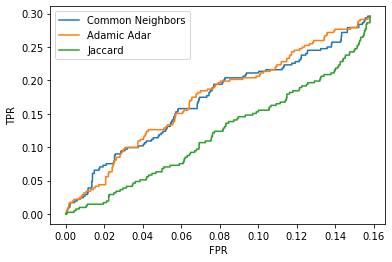

In [14]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

A simple way to summarize the results offered by the ROC curve is through its AUC

In [15]:
from sklearn.metrics import auc

print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")

Area Under Roc Curve (AUROC)
Common Neigh.: 	 0.026832485313825823
Adamic Adar: 	 0.02725982481278175
Jaccard: 	 0.018894838921578106


<a id="conclusion"></a>
## 3. Conclusions ([to top](#top))

In this notebook we introduced the basic facilities offered by ``linkpred``.

For any issue, suggestion, bug report refer the official [GitHub repository](https://github.com/rafguns/linkpred) of the project.